# Installing dependencies

In [2]:
!pip install -q -U tqdm
!pip install -q -U spacy
!pip install -q -U gensim
!pip install -q -U nltk
!pip install -q -U bs4
!pip install -q -U spacymoji
!pip install -q -U transformers
!pip install -q -U pytorch-pretrained-bert
!pip install -q -U fse
!pip install -q -U skorch
!pip install -q -U Unidecode


     |████████████████████████████████| 71kB 5.1MB/s 
     |████████████████████████████████| 24.2MB 1.3MB/s 
     |████████████████████████████████| 1.4MB 8.6MB/s 
     |████████████████████████████████| 51kB 5.4MB/s 
     |████████████████████████████████| 665kB 6.3MB/s 
     |████████████████████████████████| 3.8MB 17.5MB/s 
     |████████████████████████████████| 890kB 61.7MB/s 
     |████████████████████████████████| 1.1MB 54.5MB/s 
     |████████████████████████████████| 133kB 9.2MB/s 
     |████████████████████████████████| 112kB 9.0MB/s 
     |████████████████████████████████| 32.8MB 91kB/s 
     |████████████████████████████████| 4.9MB 59.3MB/s 
     |████████████████████████████████| 276kB 56.1MB/s 
     |████████████████████████████████| 122kB 9.7MB/s 
     |████████████████████████████████| 245kB 9.8MB/s 


In [0]:
%%capture
import spacy

SPACY_CORE_MODEL = 'es_core_news_md'
spacy.cli.download(SPACY_CORE_MODEL)

# Mounting drive

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/My Drive/Sentime/data

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Sentime/data


# Load datasets

In [0]:
import os
import pandas as pd
import numpy as np

from pathlib import Path

DATA_PATH = "/content/gdrive/My Drive/Sentime/data"
pretrained_w2v_path = Path(os.path.join(DATA_PATH, "embeddings", "SBW-vectors-300-min5.bin.gz"))
train_data_path = Path(os.path.join(DATA_PATH, "train"))
val_data_path = Path(os.path.join(DATA_PATH, "validation"))
test_data_path = Path(os.path.join(DATA_PATH, "test"))
model_dir = Path(os.path.join(DATA_PATH, "model"))

def read_data(data_dir):
    df = pd.read_csv(data_dir/'data.csv')
    idx_mixed = df[df.sentiment == 'MIXED'].index
    df.drop(idx_mixed, axis = 0, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df


train_df = read_data(train_data_path)
val_df = read_data(val_data_path)
test_df = read_data(test_data_path)

In [6]:
train_df.head()

,tweet,sentiment
0,cuando tu lugar de trabajo también se conviert...,NEUTRAL
1,adivinen a quién me voy a llevar a pasear por ...,NEUTRAL
2,rap en huitoto lengua de la amazonía en letici...,NEUTRAL
3,extrañare esto,NEGATIVE
4,y la verdad es que no me quiero de casa :(,NEGATIVE


In [7]:
train_df.tweet.isna().sum()

1

In [0]:
train_df.dropna(inplace=True) # drop nan

In [9]:
val_df.head()

,tweet,sentiment
0,disfruta de consejos útiles recetas y guías pa...,POSITIVE
1,when casper mágico said “tú me rompiste el cor...,POSITIVE
2,quinta llamada de 10 minutos esperamdo a q el ...,NEGATIVE
3,en san andrés propone al gobierno fortalecer e...,NEUTRAL
4,durante el periodo de aislamiento domiciliario...,NEUTRAL


In [10]:
val_df.tweet.isna().sum()

1

In [0]:
val_df.dropna(inplace=True) # drop nan

In [12]:
test_df.head()

,tweet,sentiment
0,unidos acabarán con bogotá,NEUTRAL
1,claudia lópez será investigada por la fiscalía...,NEGATIVE
2,y después del festivo el a partir del lunes 4 ...,NEUTRAL
3,mas claro y real no puede ser he aprendido mas...,POSITIVE
4,lo que es pa uno es pa uno así hayan mil perso...,NEGATIVE


In [13]:
test_df.tweet.isna().sum()

1

In [0]:
test_df.dropna(inplace=True) # drop nan

# Visualize classes proportions

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

def plot_classes_proportion(df, title="train classes proportion"):
    plot_data = df["sentiment"].value_counts()
    x = plot_data.index.values
    y = plot_data.values

    
    plt.figure(figsize=(8,5))
    fig = sns.barplot(x=x, y=y, orient="v", palette="hls")

    plt.ylabel("num_tweets")
    plt.title(title)
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


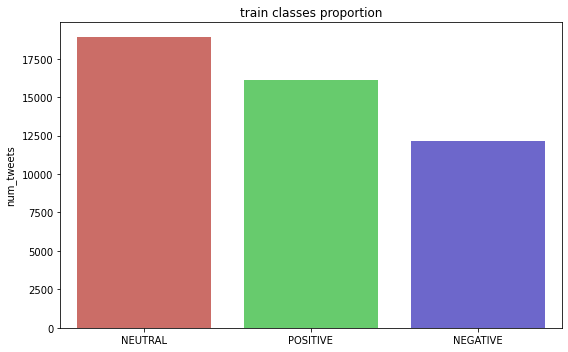

In [16]:
plot_classes_proportion(train_df)

Our data is not balanced, let's balance

## Balance the dataset

In [0]:
from sklearn.utils import resample

def balance_dataset(df, order):
    class_distribution = df["sentiment"].value_counts()
    minority_shape = df[df.sentiment == order[0]].shape[0]

    df_list = [df[df.sentiment == order[0]]]
    for cls in order[1:]:
        df_temp = df[df.sentiment == cls]
        df_down_sample = resample(df_temp, replace=False, n_samples = minority_shape,
                                   random_state=123)
        df_list.append(df_down_sample)

    df_downsampled = pd.concat(df_list)
    # shuffle
    df_downsampled = df_downsampled.sample(frac = 1)
    df_downsampled.reset_index(drop=True, inplace=True)
    return df_downsampled

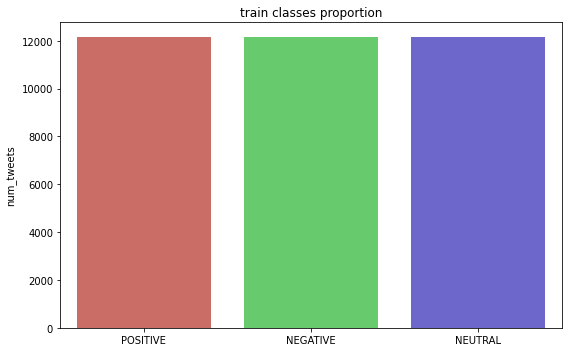

In [18]:
ORDER = ["NEGATIVE", "POSITIVE", "NEUTRAL"]
train_df = balance_dataset(train_df, order=ORDER)

plot_classes_proportion(train_df)

In [19]:
train_df.head()

,tweet,sentiment
0,como no amar lo que haces si todos los días re...,POSITIVE
1,esto es dani hpta,NEGATIVE
2,en tarima jorge ivan,NEUTRAL
3,a mi me da un pesar de usted toda patética que...,NEGATIVE
4,somos olvidados en la vida y recordados en la ...,NEGATIVE


## Preprocess data

In [0]:
from tqdm import tqdm
tqdm.pandas(desc="Preprocess data")

In [0]:
# Import Spacy:
import spacy
from spacymoji import Emoji

nlp = spacy.load(SPACY_CORE_MODEL)
# Add emoji detection
emoji = Emoji(nlp, merge_spans=False)
nlp.add_pipe(emoji, first=True)

def tokenizer_tweet(tweet):
    vector = nlp(tweet)
    # Remove all punctuation marks
    vector = [token for token in vector if not token.is_punct]
    # Remove numbers or amount representation
    vector = [token for token in vector if not token.like_num]
    # Remove emoji
    vector = [token for token in vector if not token._.is_emoji]
    # Get text and lower
    vector = [token.text.lower() for token in vector]
    
    return vector

In [22]:
train_df["tweet_clean"] = train_df["tweet"].progress_apply(lambda x: tokenizer_tweet(x))

Preprocess data: 100%|██████████| 36474/36474 [04:39<00:00, 130.34it/s]


In [23]:
val_df["tweet_clean"] = val_df["tweet"].progress_apply(lambda x: tokenizer_tweet(x))

Preprocess data: 100%|██████████| 9397/9397 [01:14<00:00, 125.84it/s]


In [24]:
test_df["tweet_clean"] = test_df["tweet"].progress_apply(lambda x: tokenizer_tweet(x))

Preprocess data: 100%|██████████| 2960/2960 [00:26<00:00, 113.58it/s]


In [25]:
train_df.head()

,tweet,sentiment,tweet_clean
0,como no amar lo que haces si todos los días re...,POSITIVE,"[como, no, amar, lo, que, haces, si, todos, lo..."
1,esto es dani hpta,NEGATIVE,"[esto, es, dani, hpta]"
2,en tarima jorge ivan,NEUTRAL,"[en, tarima, jorge, ivan]"
3,a mi me da un pesar de usted toda patética que...,NEGATIVE,"[a, mi, me, da, un, pesar, de, usted, toda, pa..."
4,somos olvidados en la vida y recordados en la ...,NEGATIVE,"[somos, olvidados, en, la, vida, y, recordados..."


# Load w2v embedding and retrained

In [0]:
from gensim.models.keyedvectors import KeyedVectors
from gensim.models import Word2Vec
import logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s", level=logging.INFO)
logger = logging.getLogger()

In [0]:
train_data = [tweet_clean for tweet_clean in list(train_df["tweet_clean"].values) 
                                        + list(val_df["tweet_clean"].values) + list(test_df["tweet_clean"].values)]

In [28]:
# https://github.com/dccuchile/spanish-word-embeddings
# Word2Vec embeddings from SBWC
w2v_parameters = {"min_count": 0, "size": 300, "sg": 1, "window": 5, "iter": 25, "negative": 20, "workers": -1}

w2v_model = Word2Vec(**w2v_parameters)
w2v_model.build_vocab(train_data, progress_per=10000)
w2v_model.intersect_word2vec_format(pretrained_w2v_path, binary=True)
w2v_model.train(train_data, total_examples=w2v_model.corpus_count, epochs=w2v_model.epochs)

2020-05-29 23:56:27,027 : INFO : collecting all words and their counts
2020-05-29 23:56:27,028 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-05-29 23:56:27,066 : INFO : PROGRESS: at sentence #10000, processed 139784 words, keeping 19929 word types
2020-05-29 23:56:27,107 : INFO : PROGRESS: at sentence #20000, processed 278454 words, keeping 30091 word types
2020-05-29 23:56:27,139 : INFO : PROGRESS: at sentence #30000, processed 417562 words, keeping 38075 word types
2020-05-29 23:56:27,176 : INFO : PROGRESS: at sentence #40000, processed 557810 words, keeping 44549 word types
2020-05-29 23:56:27,213 : INFO : collected 51049 word types from a corpus of 717586 raw words and 48831 sentences
2020-05-29 23:56:27,215 : INFO : Loading a fresh vocabulary
2020-05-29 23:56:27,411 : INFO : effective_min_count=0 retains 51049 unique words (100% of original 51049, drops 0)
2020-05-29 23:56:27,412 : INFO : effective_min_count=0 leaves 717586 word corpus (100% of or

(0, 0)

In [0]:
# Create a fast sentece embedding
# https://github.com/oborchers/Fast_Sentence_Embeddings
from fse.models import SIF #Import Smooth inverse frequency
from fse import IndexedList
logging.disable(logging.CRITICAL)

In [30]:
fse_train_data = IndexedList(train_data)
fse_model = SIF(w2v_model, workers=2, lang_freq="es")
fse_model.train(fse_train_data)

(48825, 717586)

In [31]:
fse_model.wv.most_similar("feliz")

[('contenta', 0.7562954425811768),
 ('felices', 0.7461493611335754),
 ('contento', 0.7461210489273071),
 ('emocionada', 0.6960129141807556),
 ('emocionado', 0.6868836879730225),
 ('orgulloso', 0.67653489112854),
 ('felicidad', 0.6745392084121704),
 ('orgullosa', 0.6712003946304321),
 ('alegría', 0.669589102268219),
 ('agradecida', 0.6607950329780579)]

## Prepare data and embeddings

In [32]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_df.sentiment.values)

le.transform(le.classes_)

array([0, 1, 2])

In [0]:
def get_embeddings(df):
    X = np.zeros(shape=(df.shape[0], 300))
    for i, val in tqdm(enumerate(df.tweet_clean.values)):
        X[i] = fse_model.infer([(val, 0)])
    y = le.transform(df.sentiment.values)
    return X, y

In [34]:
X_train, y_train = get_embeddings(train_df)

36474it [00:11, 3239.42it/s]


In [35]:
X_val, y_val = get_embeddings(val_df)

9397it [00:02, 3150.27it/s]


In [36]:
X_test, y_test = get_embeddings(test_df)

2960it [00:01, 2941.27it/s]


In [37]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((36474, 300), (9397, 300), (2960, 300), (36474,), (9397,), (2960,))

# Pytorch model

In [0]:
from torch.utils.data import Dataset, DataLoader

In [0]:
class tweets_embedding_dataset(Dataset):
    def __init__(self, tweet_embedding, labels):
        """
        Constructor class of our custom pytorch dataset

        Args:
            tweet_embedding -- matrix tweets x words from tfidf embedding
            labels -- numpy array of shape (tweets, ) with values 0 and 2
                    0: Negative
                    1: Neutral
                    2: Positive
        """
        self.data = tweet_embedding
        self.labels = labels
        self.class_names = ['0 - NEGATIVE', '1 - NEUTRAL', '2 - POSITIVE']

    def __len__(self):
        """
        Return size of dataset
        """
        return self.data.shape[0]

    def __getitem__(self, idx):
        """
        get item of our dataset
        """
        return self.data[idx], self.labels[idx]       

In [0]:
train_dataset = tweets_embedding_dataset(X_train, y_train)
val_dataset = tweets_embedding_dataset(X_val, y_val)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64) # We are going to use full batch for training
val_dataloader = DataLoader(val_dataset, shuffle=True, batch_size=64) # We are going to use full batch for training

datasets = {"train": train_dataset, "val": val_dataset}
dataloaders = {"train": train_dataloader, "val": val_dataloader}
dataset_sizes = {"train": X_train.shape[0], "val": X_val.shape[0]}

In [0]:
import torch
import time
import copy

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.optim import lr_scheduler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class Net(nn.Module):
    """Class neural net with the architecture definition"""
    def __init__(self, input_size, hidden_size, output_size, n_layers, 
                 bidirectional, dropout):
        
        super(Net, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, 
                            num_layers=n_layers,
                            bidirectional=bidirectional,
                            dropout=dropout)

        self.head_layers = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(2*hidden_size, hidden_size),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x.view(len(x), 1, -1))
        x = self.head_layers(lstm_out.view(len(x), -1))
        return x

In [0]:
def train_model(model, criterion, optimizer, num_epochs=25):
    """
    Train the model
    Args: 
      model -- neural net definition
      criterion -- Loss criterio
      optimizer -- Optimizer algorithm
      scheduler -- scheduler tu decay learning rate
      num_epochs -- num_epochs to train the conv net
    Return:
      model -- best_model
    """
    since = time.time()

    losses = {"train": [], "val": []}
    accuracies = {"train": [], "val": []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):

        
        print(f'Epoch: {epoch+1:02}')

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.cuda().float()
                labels = labels.cuda()
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    # Calculate loss
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            losses[phase].append(epoch_loss)
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            accuracies[phase].append(epoch_acc)

            if phase == 'val':
                print(f'\t Val. Loss: {epoch_loss:.3f} |  Val. Acc: {epoch_acc*100:.3f}%')
                
            elif phase == 'train':
                print(f'\tTrain Loss: {epoch_loss:.3f} | Train Acc: {epoch_acc*100:.3f}%')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, losses, accuracies, best_acc

In [44]:
EMBEDDING_DIM = X_train.shape[1]
HIDDEN_DIM = 100
OUTPUT_DIM = 3
N_LAYERS = 3
BIDIRECTIONAL = True
DROPOUT = 0.5

model = Net(EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, 
            BIDIRECTIONAL, DROPOUT).cuda()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters())

# Train
model, losses, accuracies, best_acc = train_model(model, criterion, optimizer, num_epochs=40)

Epoch: 01
	Train Loss: 0.995 | Train Acc: 46.236%
	 Val. Loss: 0.800 |  Val. Acc: 66.479%
Epoch: 02
	Train Loss: 0.877 | Train Acc: 57.134%
	 Val. Loss: 0.754 |  Val. Acc: 68.692%
Epoch: 03
	Train Loss: 0.862 | Train Acc: 57.973%
	 Val. Loss: 0.754 |  Val. Acc: 69.001%
Epoch: 04
	Train Loss: 0.853 | Train Acc: 58.675%
	 Val. Loss: 0.733 |  Val. Acc: 69.831%
Epoch: 05
	Train Loss: 0.850 | Train Acc: 58.529%
	 Val. Loss: 0.731 |  Val. Acc: 70.161%
Epoch: 06
	Train Loss: 0.841 | Train Acc: 58.850%
	 Val. Loss: 0.751 |  Val. Acc: 68.352%
Epoch: 07
	Train Loss: 0.846 | Train Acc: 58.623%
	 Val. Loss: 0.734 |  Val. Acc: 69.416%
Epoch: 08
	Train Loss: 0.842 | Train Acc: 58.669%
	 Val. Loss: 0.737 |  Val. Acc: 69.522%
Epoch: 09
	Train Loss: 0.838 | Train Acc: 59.124%
	 Val. Loss: 0.747 |  Val. Acc: 69.022%
Epoch: 10
	Train Loss: 0.834 | Train Acc: 59.009%
	 Val. Loss: 0.734 |  Val. Acc: 68.958%
Epoch: 11
	Train Loss: 0.827 | Train Acc: 59.429%
	 Val. Loss: 0.719 |  Val. Acc: 70.310%
Epoch: 12


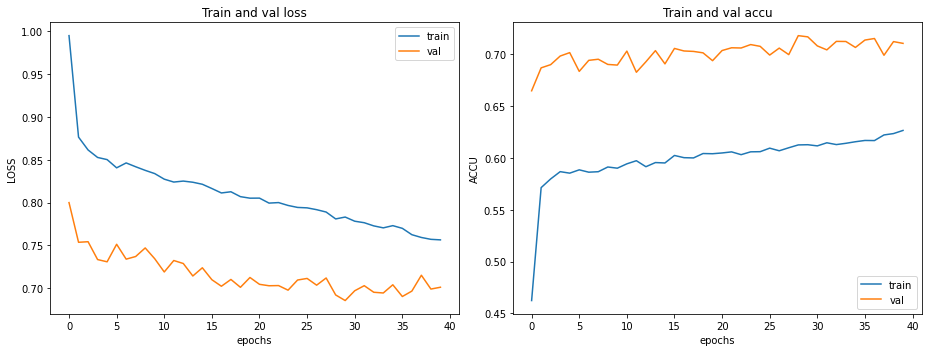

In [45]:
def plot_losses_accuracies(losses, accuracies, width=13, height=5):
    """
    Plot losses and accuracies in each epoch on train and val set
    Args:
        losses -- python dictionary
                    {"train": loss list, "val": loss list}
        accuracies -- python dictionary
                    {"train": accuracies list, "val": accuracies list}
        width -- plot width config
        height -- plot height config
    """         
    plt.figure(figsize=(width, height))    
    results = {"loss": losses, "accu": accuracies}

    idx_plot = 0
    for type_plot, value in results.items():
        plt.subplot(1,2, idx_plot+1)
        plt.plot(value["train"], label="train")
        plt.plot(value["val"], label="val")
        plt.title("Train and val {0}".format(type_plot))
        plt.ylabel("{0}".format(type_plot).upper())
        plt.xlabel("epochs")
        plt.legend()

        idx_plot += 1
    plt.tight_layout()
    plt.show()

plot_losses_accuracies(losses, accuracies)

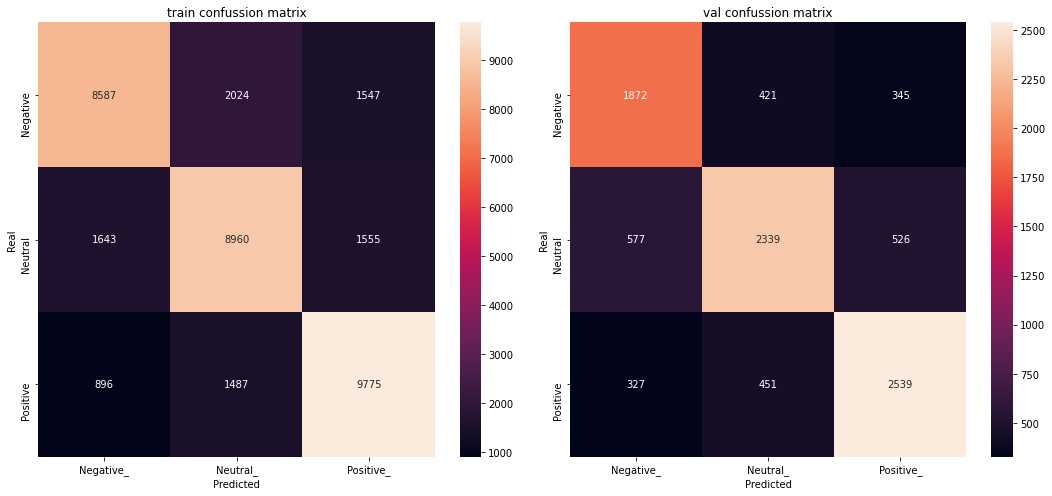

In [46]:
from sklearn.metrics import classification_report

def plot_confusion_matrix_training_results(datasets, dataset_sizes, model, width=13, height=7):
    """
    Plot confusion matrix for every train, test set, using sklearn functions

    Args:
        datasets -- python dictionary 
                        {'train': traindatasets, 'val': valdatasets}
        dataset_sizes -- python dictionary
                        {'train': trainsize, 'val': valsize}
        model -- trained model
        width -- plot configuration width figsize
        height -- plot configuration height figsize
    """
    # Set model to eval
    model.eval()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(width, height))
    cls_report = {}
    for idx_plot, phase in enumerate(['train', 'val']):
        predictions = []
        real = []
        for data, label in datasets[phase]:
            entry = torch.Tensor(data).cuda().float().view([1, -1])
            with torch.no_grad():
                outputs = model(entry)
                _, preds = torch.max(outputs, 1)
            predictions.append(preds.cpu().numpy())
            real.append(label)

        conf_matrix = confusion_matrix(real, predictions, [0,1,2])
        fig = sns.heatmap(pd.DataFrame(data=conf_matrix, columns=["Negative_", "Neutral_", "Positive_"], 
                                       index=["Negative", "Neutral", "Positive"]), annot=True, fmt='d', ax=ax[idx_plot])
        
        # save classification report
        cls_report[phase] = classification_report(real, predictions, target_names = ["Negative", "Neutral", "Positive"])
        ax[idx_plot].set_title("{0} confussion matrix".format(phase))
        ax[idx_plot].set_ylabel("Real")
        ax[idx_plot].set_xlabel("Predicted")
    plt.tight_layout()
    plt.show()

    return cls_report

cls_report = plot_confusion_matrix_training_results(datasets, dataset_sizes, model, width=15)

In [47]:
print(cls_report["train"])

              precision    recall  f1-score   support

    Negative       0.77      0.71      0.74     12158
     Neutral       0.72      0.74      0.73     12158
    Positive       0.76      0.80      0.78     12158

    accuracy                           0.75     36474
   macro avg       0.75      0.75      0.75     36474
weighted avg       0.75      0.75      0.75     36474



In [48]:
print(cls_report["val"])

              precision    recall  f1-score   support

    Negative       0.67      0.71      0.69      2638
     Neutral       0.73      0.68      0.70      3442
    Positive       0.74      0.77      0.75      3317

    accuracy                           0.72      9397
   macro avg       0.72      0.72      0.72      9397
weighted avg       0.72      0.72      0.72      9397



#Predictions

In [49]:
model.eval()
with torch.no_grad():
    outputs = model(torch.Tensor(X_test).cuda().float())
    _, preds = torch.max(outputs, 1)

sum(preds.cpu().numpy() == y_test)/len(y_test) * 100

72.63513513513513

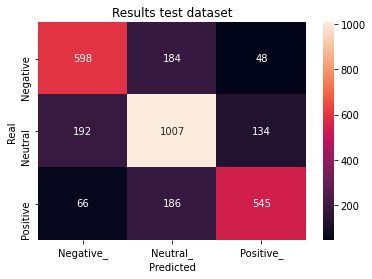

In [50]:
conf_matrix = confusion_matrix(y_test, preds.cpu().numpy(), [0,1,2])
fig = sns.heatmap(pd.DataFrame(data=conf_matrix, columns=["Negative_", "Neutral_", "Positive_"], index=["Negative", "Neutral", "Positive"]), annot=True, fmt='d')
cls_report["test"] = classification_report(y_test, preds.cpu().numpy(), target_names = ["Negative", "Neutral", "Positive"])
fig.plot()
plt.xlabel("Predicted")
plt.ylabel("Real")
plt.title("Results test dataset")
plt.show()

In [51]:
print(cls_report["test"])

              precision    recall  f1-score   support

    Negative       0.70      0.72      0.71       830
     Neutral       0.73      0.76      0.74      1333
    Positive       0.75      0.68      0.72       797

    accuracy                           0.73      2960
   macro avg       0.73      0.72      0.72      2960
weighted avg       0.73      0.73      0.73      2960



# Save model

In [0]:
import dill
import os

embedding_model_path = os.path.join(model_dir, 'embedding_model')
model_path = os.path.join(model_dir, 'model')

with open(embedding_model_path,'wb') as f:
  fse_model.save(f)

torch.save(model, model_path)

In [53]:
from fse.models import SIF

fse_model = SIF.load(embedding_model_path)
model = torch.load(model_path)

model.eval()

Net(
  (lstm): LSTM(300, 100, num_layers=3, dropout=0.5, bidirectional=True)
  (head_layers): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=200, out_features=100, bias=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=3, bias=True)
    (5): Dropout(p=0.5, inplace=False)
  )
)

In [0]:
import spacy
from spacymoji import Emoji

nlp = spacy.load(SPACY_CORE_MODEL)
emoji = Emoji(nlp, merge_spans=False)
nlp.add_pipe(emoji, first=True)

def preprocess(tweet):
    vector = nlp(tweet)
    vector = [token for token in vector if not token.is_punct]
    vector = [token for token in vector if not token.like_num]
    vector = [token for token in vector if not token._.is_emoji]
    vector = [token.text.lower() for token in vector]
    vector = fse_model.infer([(vector, 0)])
    return vector

In [55]:
tweets = ['Estoy triste con pumarejo', 'Amo a char con todo mi ❤️', 'Esto del coronavirus me tiene triste, jejeje xd']
tweets = [preprocess(tweet) for tweet in tweets]

outputs = model(torch.Tensor(tweets).cuda().float())
_, preds = torch.max(outputs, 1)

with torch.no_grad():
  print(preds.cpu().numpy() - 1)

[-1  1 -1]
